In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from functools import reduce
import matplotlib.dates as mdates
from math import ceil
from datetime import datetime, timedelta
# from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [182]:
df = pd.read_csv('dataset_mood_smartphone.csv')

In [183]:
"""
Check stats on NaN values and Remove NaN values
"""
# df with NaN values
df_na = df[pd.isna(df['value'])]

# Counts NaN values for each variable
df_na_variables = df_na['variable'].value_counts()
df = df.dropna()

In [184]:
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date

# df['time'] = pd.to_datetime(df['time'])
# df['date'] = df['time'].dt.floor('D')  # This normalizes the time part to 00:00, keeping it as Timestamp

df['hour'] = df['time'].dt.hour
df['time_of_day'] = df['time'].dt.time
unique_variables = df['variable'].unique()
participants = df['id'].unique()
days = df['date'].unique()

In [185]:
"""
Delete time gabs in mood AS14.01, AS14.12, AS14,17
"""

# AS14.01
# Ensure 'date' is in datetime format for easy comparison
# df['date'] = pd.to_datetime(df['date'])

# Define the start and end of the date range to exclude
start_date = pd.to_datetime('2014-02-26')
end_date = pd.to_datetime('2014-03-20')

# Exclude data points for 'id' = 'AS14.01' within the specified date range
df = df[~((df['id'] == 'AS14.01') & (df['date'] >= start_date) & (df['date'] <= end_date))]

# Now filtered_df contains the data excluding the specified date range for 'id' = 'AS14.01'

# AS14.12
# 2014-03-15 - 2014, 3, 26
# Ensure 'date' is in datetime format for easy comparison
df['date'] = pd.to_datetime(df['date'])

# Define the start and end of the date range to exclude
start_date = pd.to_datetime('2014-03-15')
end_date = pd.to_datetime('2014-03-26')

# Exclude data points for 'id' = 'AS14.01' within the specified date range
df = df[~((df['id'] == 'AS14.12') & (df['date'] >= start_date) & (df['date'] <= end_date))]

# AS14.17
# 2014, 3, 20

# Ensure 'date' is in datetime format for easy comparison
df['date'] = pd.to_datetime(df['date'])

# Define the start and end of the date range to exclude
start_date = pd.to_datetime('2014-03-04')
end_date = pd.to_datetime('2014-03-20')

# Exclude data points for 'id' = 'AS14.01' within the specified date range
df = df[~((df['id'] == 'AS14.17') & (df['date'] >= start_date) & (df['date'] <= end_date))]

print(df)

        Unnamed: 0       id                    time        variable   value  \
7                8  AS14.01 2014-03-21 09:00:00.000            mood   6.000   
8                9  AS14.01 2014-03-21 11:00:00.000            mood   6.000   
9               10  AS14.01 2014-03-21 15:00:00.000            mood   7.000   
10              11  AS14.01 2014-03-21 19:00:00.000            mood   6.000   
11              12  AS14.01 2014-03-21 21:00:00.000            mood   6.000   
...            ...      ...                     ...             ...     ...   
376907     2770399  AS14.30 2014-04-11 07:51:16.948  appCat.weather   8.032   
376908     2772465  AS14.30 2014-04-19 11:00:32.747  appCat.weather   3.008   
376909     2774026  AS14.30 2014-04-26 10:19:07.434  appCat.weather   7.026   
376910     2774133  AS14.30 2014-04-27 00:44:48.450  appCat.weather  23.033   
376911     2784435  AS14.32 2014-04-07 18:25:14.036  appCat.weather  22.431   

             date  hour      time_of_day  
7      2

In [186]:
"""
Cut out all mood measurements outside the time frame 
08:00 - 22:00
"""

# Only cut it out for mood
# df = df[
#     (df['variable'] != 'mood') | 
#     ((df['time'].dt.hour >= 8) & (df['time'].dt.hour < 22))
# ]

# Cut it out for all variables
df = df[
    ((df['time'].dt.hour >= 8) & (df['time'].dt.hour < 22))
]

print(df)

        Unnamed: 0       id                    time        variable   value  \
7                8  AS14.01 2014-03-21 09:00:00.000            mood   6.000   
8                9  AS14.01 2014-03-21 11:00:00.000            mood   6.000   
9               10  AS14.01 2014-03-21 15:00:00.000            mood   7.000   
10              11  AS14.01 2014-03-21 19:00:00.000            mood   6.000   
11              12  AS14.01 2014-03-21 21:00:00.000            mood   6.000   
...            ...      ...                     ...             ...     ...   
376905     2769513  AS14.30 2014-04-07 18:16:49.107  appCat.weather  60.829   
376906     2769514  AS14.30 2014-04-07 18:21:04.197  appCat.weather   3.018   
376908     2772465  AS14.30 2014-04-19 11:00:32.747  appCat.weather   3.008   
376909     2774026  AS14.30 2014-04-26 10:19:07.434  appCat.weather   7.026   
376911     2784435  AS14.32 2014-04-07 18:25:14.036  appCat.weather  22.431   

             date  hour      time_of_day  
7      2

In [187]:
"""
Cut out all measurements on all variables for each participant outside the timeframe in which mood was measured
"""
# Initialize an empty DataFrame to hold the filtered data
filtered_df = pd.DataFrame()

for participant in participants:
    # Get the mood data for the current participant
    id_df = df[(df['variable'] == 'mood') & (df['id'] == participant)]
    
    # Calculate start and end dates for mood measurements
    start_date = id_df['date'].min()
    end_date = id_df['date'].max()
    
    # Filter the original df to keep rows within the date range for this participant
    participant_data = df[df['id'] == participant]
    participant_filtered = participant_data[(participant_data['date'] >= start_date) & (participant_data['date'] <= end_date)]
    
    # Append the filtered data to the cumulative DataFrame
    filtered_df = pd.concat([filtered_df, participant_filtered], ignore_index=True)
    
# print(filtered_df)
df = filtered_df
# print(df)
# # Now, filtered_df contains only the data for each participant within the date ranges of their mood measurements.
# 
# # Print df to check results
# print(df[(df['variable'] == 'mood')])

In [188]:
"""
Detecting outliers with IQR
"""
def get_outlier_indices(group, threshold=6.0):
    Q1 = group['value'].quantile(0.25)
    Q3 = group['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    # Find outliers and return their indices
    outlier_mask = (group['value'] < lower_bound) | (group['value'] > upper_bound)
    if outlier_mask.any():
        return group[outlier_mask].index.tolist()
    else:
        return []

# Exclude 'mood' data before applying outlier detection
df_filtered = df[df['variable'] != 'mood']

# Get indices of outliers in each group
outlier_indices = df_filtered.groupby('variable').apply(get_outlier_indices).explode()

# Convert Series to list, filtering out NaN values if any (resulting from empty lists)
outlier_indices = [idx for idx in outlier_indices if pd.notna(idx)]

# Drop the outliers by index to create a new DataFrame without outliers
df_without_outliers = df.drop(outlier_indices)

# Print the original and new DataFrame sizes to see the effect
print(f"Original DataFrame size: {len(df)}")
print(f"DataFrame size without outliers: {len(df_without_outliers)}")

df = df_without_outliers

Original DataFrame size: 301027
DataFrame size without outliers: 292543


In [189]:
"""
Average data for each day, for each participant and impude values on all predictors in each missing day
"""
# non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence']
df_time = df[~df['variable'].isin(non_time_variables)]
# df_non_time = df[df['variable'].isin(non_time_variables)]

all_df_id = []
for participant in participants:
    separate_var_id_df_combined = []
    # Filter data for the current participant and sort it by date
    id_df = df[df['id'] == participant].sort_values(by='date')

    # Group and calculate averages for non-time variables
    id_df_non_time = id_df[id_df['variable'].isin(non_time_variables)]
    id_daily_avg_df_non_time = id_df_non_time.groupby(['date', 'variable'])['value'].mean().reset_index()

    # Group and calculate sums for time variables
    id_df_time = id_df[~id_df['variable'].isin(non_time_variables)]
    id_daily_avg_df_time = id_df_time.groupby(['date', 'variable'])['value'].sum().reset_index()

    # Combine non-time and time data
    id_daily_avg_df = pd.concat([id_daily_avg_df_non_time, id_daily_avg_df_time], ignore_index=True)

    # Define end and start dates
    all_dates = pd.date_range(start=id_df['date'].min(), end=id_df['date'].max(), freq='D')
    
    for variable in unique_variables:
        id_variable_df = id_daily_avg_df[id_daily_avg_df['variable'] == variable].copy()

        # Add missing dates for each variable
        missing_dates = all_dates.difference(id_variable_df['date'])
        missing_rows = pd.DataFrame({
            'date': missing_dates,
            'variable': variable,
            'value': pd.NA
        })
        id_variable_df = pd.concat([id_variable_df, missing_rows], ignore_index=True).sort_values(by='date')
        
        if variable in non_time_variables:
            # Impute missing values: forward fill, then backward fill
            id_variable_df['value'] = id_variable_df['value'].interpolate()
            # id_variable_df['value'].fillna(method='bfill', inplace=True)  # Handle cases where the first value is missing
        else:
            # Replace any remaining NA with zeros (for example if all values are NA)
            id_variable_df['value'].fillna(0, inplace=True)
        
        
        # # Impute missing values: forward fill, then backward fill
        # id_variable_df['value'].fillna(method='ffill', inplace=True)
        # id_variable_df['value'].fillna(method='bfill', inplace=True)  # Handle cases where the first value is missing
        # 
        # # Replace any remaining NA with zeros (for example if all values are NA)
        # id_variable_df['value'].fillna(0, inplace=True)

        separate_var_id_df_combined.append(id_variable_df)

    # Attach participant ID and combine all variables into a single DataFrame
    combined_df_id = pd.concat(separate_var_id_df_combined, ignore_index=True)
    combined_df_id['id'] = participant
    
    all_df_id.append(combined_df_id)
# Concatenate all participants' data into a single DataFrame
all_df_id = pd.concat(all_df_id, ignore_index=True)

# Print the combined DataFrame
print(all_df_id)
date_ranges = all_df_id.groupby('id')['date'].agg(start_date='min', end_date='max').reset_index()

# Save the DataFrame to a CSV file
all_df_id.to_csv('all_df_id.csv', index=False)
# print(date_ranges)

            date        variable  value       id
0     2014-03-21            mood   6.20  AS14.01
1     2014-03-22            mood   6.40  AS14.01
2     2014-03-23            mood   6.80  AS14.01
3     2014-03-24            mood   6.00  AS14.01
4     2014-03-25            mood   6.75  AS14.01
...          ...             ...    ...      ...
24277 2014-05-27  appCat.weather   0.00  AS14.33
24278 2014-05-28  appCat.weather   0.00  AS14.33
24279 2014-05-29  appCat.weather   0.00  AS14.33
24280 2014-05-30  appCat.weather   0.00  AS14.33
24281 2014-05-31  appCat.weather   0.00  AS14.33

[24282 rows x 4 columns]


In [190]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# 
# # Create a copy of the DataFrame to avoid modifying the original data while iterating
# df_normalized = all_df_id.copy()
# 
# # Instantiate the scaler
# scaler = MinMaxScaler()
# 
# # Normalize data for each variable
# for variable in unique_variables:
#     # Select rows corresponding to the current variable
#     mask = df_normalized['variable'] == variable
#     
#     # Reshape data for scaling (sklearn requires data in shape [n_samples, n_features])
#     values = df_normalized.loc[mask, 'value'].values.reshape(-1, 1)
#     
#     # Apply MinMaxScaler
#     df_normalized.loc[mask, 'value'] = scaler.fit_transform(values).flatten()  # flatten to convert array back to original shape
# 
# # Now df_normalized contains the scaled 'value' for each variable


Text(0.5, 1.0, 'Correlation Heatmap of Variables')

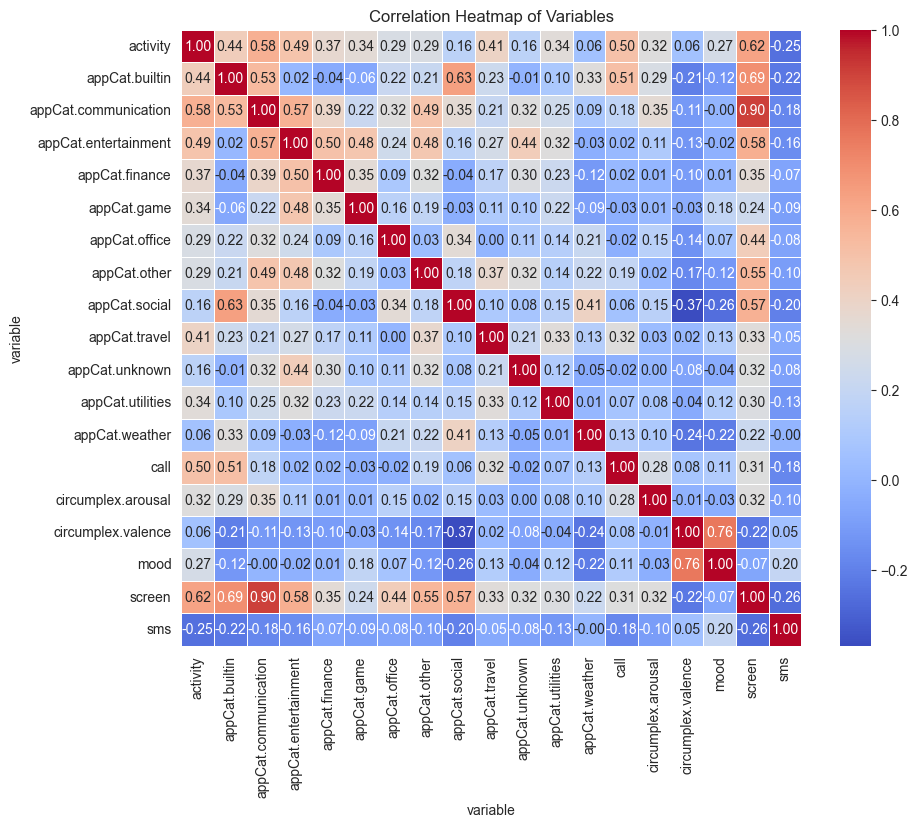

In [191]:
"""
Corr. heatmap, index on date
"""
df_pivoted = all_df_id.pivot_table(index='date', columns='variable', values='value')
corr_matrix = df_pivoted.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Variables')

In [192]:
all_entries = []
# all_entries = []
unique_variables = unique_variables.tolist()
# all_entries.append(['id', 'current_mood', 'current_date'] + unique_variables)
column_names = ['id', 'current_mood', 'current_date'] + unique_variables
# print(all_df_id)
for participant in participants:
    id_df = all_df_id[(all_df_id['id'] == participant)]
    id_df = id_df.sort_values('date')

    for current_date in id_df['date'].unique()[3:]:  # Start from the fourth record

        current_mood_series = id_df[(id_df['variable'] == 'mood') & (id_df['date'] == current_date)]['value']
        current_mood = current_mood_series.iloc[0]
        single_entry = [participant]
        single_entry.append(current_mood)
        single_entry.append(current_date)

        three_days_prior = current_date - pd.Timedelta(days=3)

        # Mask to filter data for the three days leading up to the current day
        mask = (id_df['date'] >= three_days_prior) & (id_df['date'] < current_date)
        three_days_data = id_df.loc[mask]
        # print(three_days_data)

        # Calculate means for the variables over the last three days
        mean_values = three_days_data.groupby('variable')['value'].mean().reindex(unique_variables, fill_value=0)
        single_entry.extend(mean_values.tolist())

        all_entries.append(single_entry)

# Create DataFrame from collected entries
df_3day_transformed = pd.DataFrame(all_entries, columns=column_names)

# Print the resulting DataFrame
print(df_3day_transformed)

df_3day_transformed.to_csv('df_3day_transformed.csv', index=False)


           id  current_mood current_date      mood  circumplex.arousal  \
0     AS14.01          6.00   2014-03-24  6.466667            0.333333   
1     AS14.01          6.75   2014-03-25  6.400000            0.533333   
2     AS14.01          6.60   2014-03-26  6.516667            0.500000   
3     AS14.01          7.00   2014-03-27  6.450000            0.366667   
4     AS14.01          6.40   2014-03-28  6.783333            0.266667   
...       ...           ...          ...       ...                 ...   
1192  AS14.33          6.20   2014-05-27  5.883333           -0.633333   
1193  AS14.33          8.20   2014-05-28  5.950000           -0.583333   
1194  AS14.33          7.00   2014-05-29  6.600000           -0.333333   
1195  AS14.33          7.00   2014-05-30  7.133333           -0.644444   
1196  AS14.33          7.00   2014-05-31  7.400000           -0.694444   

      circumplex.valence  activity       screen      call       sms  ...  \
0               0.500000  2.962431 

In [193]:
print(df_3day_transformed.isna().any().any())

False


In [194]:

active_subjects_day = df.groupby(['date'])['id'].unique().reset_index()

In [195]:
# """
# Average data for each day:
# """
# # non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
# non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence']
# df_time = all_df_id[~all_df_id['variable'].isin(non_time_variables)]
# 
# # For time variables, we take the mean of each day averaged over the active participants of the corresponding day
# daily_avg_df_time = df_time.groupby(['date', 'variable'])['value'].sum().reset_index()
# daily_avg_df_time['value'] = daily_avg_df_time['value'] / len(active_subjects_day['date'])
# 
# # For non-time variables, we take the mean of all the inputs for each hour
# df_non_time = all_df_id[all_df_id['variable'].isin(non_time_variables)]
# daily_avg_df_non_time = df_non_time.groupby(['date', 'variable'])['value'].mean().reset_index()
# 
# # Merges the two dataframes
# daily_avg_df = pd.concat([daily_avg_df_non_time, daily_avg_df_time], ignore_index=True)
# # print(len(daily_avg_df).unique('date'))
# print(daily_avg_df)

In [196]:
# """
# Corr. heatmap, index on date
# """
# df_pivoted = daily_avg_df.pivot_table(index='date', columns='variable', values='value')
# corr_matrix = df_pivoted.corr()
# 
# # Generate a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# plt.title('Correlation Heatmap of Variables')

In [197]:
# # df with NaN values
# df_na = daily_avg_df[pd.isna(daily_avg_df['value'])]
# print(df_na)
# 
# dates = daily_avg_df['date'].unique()
# print(df_na_variables)
# print(len(df_na_variables))

In [198]:
# df = daily_avg_df
# print(df.head(1))

In [199]:
# from statsmodels.tsa.stattools import adfuller
# 
# # Loop through each unique variable in the DataFrame
# for variable in df['variable'].unique():
#     # Filter the DataFrame to only include rows for the current variable
#     series = df[df['variable'] == variable]['value']
#     result = adfuller(series.dropna())  # Ensure to drop na to avoid errors in the test
#     
#     print(f'Results for {variable}:')
#     print('ADF Statistic: %f' % result[0])
#     print('p-value: %f' % result[1])
#     print('Critical Values:')
#     for key, value in result[4].items():
#         print('\t%s: %.3f' % (key, value))
#     print('\n')


In [200]:
# """
# Visualization of variance over time
# """
# 
# # Set 'Date' as the index of the DataFrame for easier plotting
# df.set_index('date', inplace=True)
# 
# # Setup the plot
# plt.figure(figsize=(15, 8))
# 
# # Colors for each variable
# colors = plt.cm.viridis(np.linspace(0, 1, len(df['variable'].unique())))
# 
# # Plotting normalized rolling standard deviation for each variable
# for color, variable in zip(colors, df['variable'].unique()):
#     series = df[df['variable'] == variable]['value']
#     # Normalize the series
#     normalized_series = (series - series.min()) / (series.max() - series.min())
#     rolling_std = normalized_series.rolling(window=30).std()  # 30-day rolling window
# 
#     plt.plot(rolling_std.index, rolling_std, label=f'{variable}', color=color)
# 
# plt.title('Normalized Rolling Standard Deviation of Variables')
# plt.xlabel('Date')
# plt.ylabel('Normalized Standard Deviation')
# plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
# plt.grid(True)
# plt.show()


In [201]:
# unique_variables = unique_variables.tolist()

   current_mood  mood_category
0          6.00              3
1          6.75              4
2          6.60              4
3          7.00              4
4          6.40              4


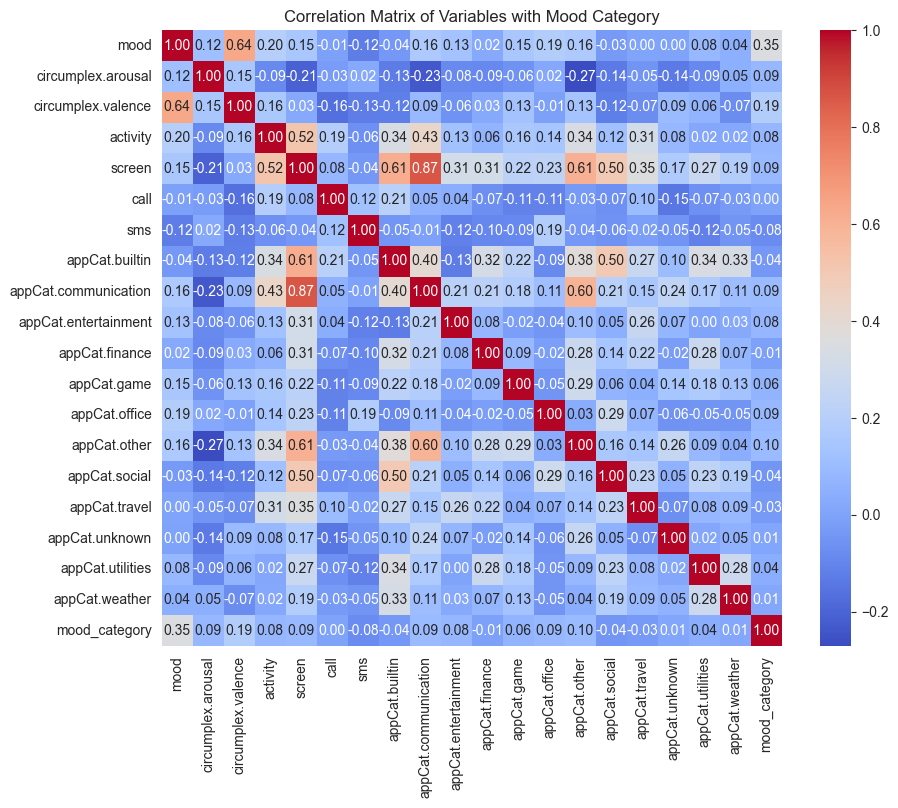

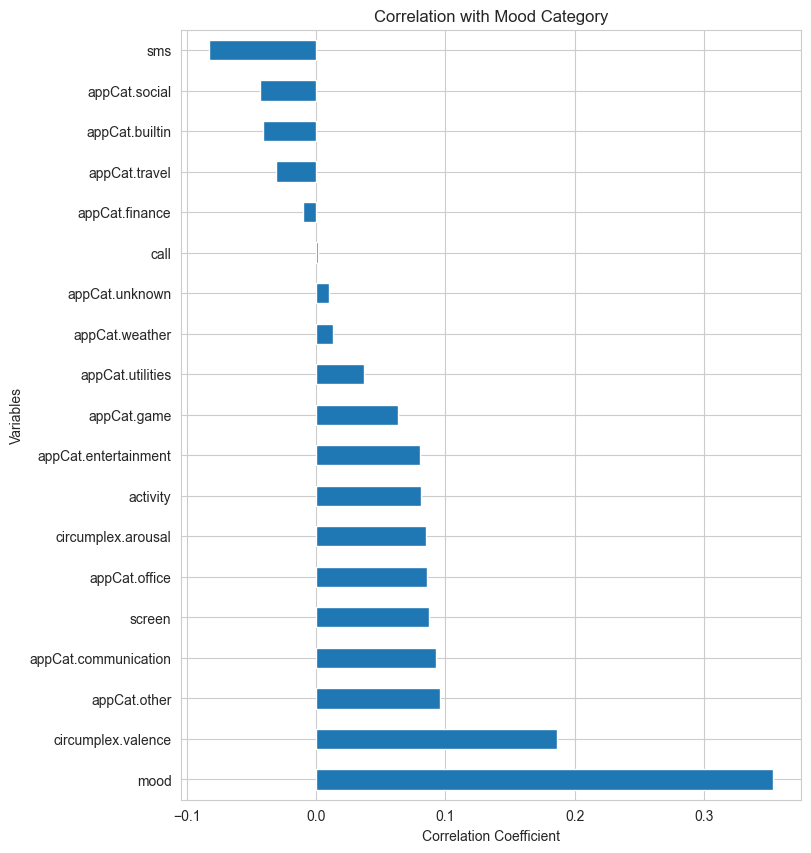

In [202]:
"""
Shows how the average of the past three days correlate with the mood of the current date. Based on this information we can pick the predictors. 
"""

# Assuming df_3day_transformed is your DataFrame
# Define bins and labels for the categorization
bins = [0, 2, 4, 6, 8, 10]  # Adjust upper limit if necessary
labels = [1, 2, 3, 4, 5]

# Use pd.cut() to categorize 'current_mood' based on the bins
df_3day_transformed['mood_category'] = pd.cut(df_3day_transformed['current_mood'], bins=bins, labels=labels, include_lowest=True, right=True)

# Convert mood_category to integer for correlation analysis
df_3day_transformed['mood_category'] = df_3day_transformed['mood_category'].astype(int)

# Print the first few rows to check 'mood_category'
print(df_3day_transformed[['current_mood', 'mood_category']].head())

# Calculate the correlation matrix after dropping non-relevant columns
correlation_vars = df_3day_transformed.drop(columns=['current_mood', 'id', 'current_date'])
corr_matrix = correlation_vars.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix of Variables with Mood Category')
plt.show()

# Plotting correlation with 'mood_category'
target_corr = corr_matrix['mood_category'].sort_values(ascending=False)
plt.figure(figsize=(8, 10))
target_corr.drop('mood_category').plot(kind='barh')  # Exclude self-correlation
plt.title('Correlation with Mood Category')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')
plt.show()


In [203]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# 
# # Assuming df_3day_transformed is your DataFrame
# # First, filter out the columns you don't want to include in the correlation analysis
# correlation_vars = df_3day_transformed.drop(columns=['current_mood', 'id', 'current_date'])
# 
# # Calculate the correlation matrix
# corr_matrix = correlation_vars.corr()
# 
# # Now, let's focus on the correlation with 'mood_category'
# target_corr = corr_matrix['mood_category'].sort_values(ascending=False)
# 
# # Plotting the correlation of features with 'mood_category'
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
# plt.title('Correlation Matrix of Variables with Mood Category')
# plt.show()
# 
# # Optionally, you can specifically plot a bar chart for correlations with 'mood_category'
# plt.figure(figsize=(8, 10))
# target_corr.drop('mood_category').plot(kind='barh')  # Exclude self-correlation
# plt.title('Correlation with Mood Category')
# plt.xlabel('Correlation Coefficient')
# plt.ylabel('Variables')
# plt.show()


In [204]:
"""
Normalize data of predictors

"""

from sklearn.preprocessing import MinMaxScaler

# Assuming df_3day_transformed is your DataFrame
scaler = MinMaxScaler()

# List of columns to exclude from normalization
exclude_cols = ['current_mood', 'id', 'current_date', 'mood_category']

# Select columns to scale
feature_cols = [col for col in df_3day_transformed.columns if col not in exclude_cols]

# Fit and transform the data
df_3day_transformed[feature_cols] = scaler.fit_transform(df_3day_transformed[feature_cols])
print(df_3day_transformed)
# Now df_3day_transformed has normalized features except for the excluded columns


           id  current_mood current_date      mood  circumplex.arousal  \
0     AS14.01          6.00   2014-03-24  0.566751            0.680851   
1     AS14.01          6.75   2014-03-25  0.551637            0.744681   
2     AS14.01          6.60   2014-03-26  0.578086            0.734043   
3     AS14.01          7.00   2014-03-27  0.562972            0.691489   
4     AS14.01          6.40   2014-03-28  0.638539            0.659574   
...       ...           ...          ...       ...                 ...   
1192  AS14.33          6.20   2014-05-27  0.434509            0.372340   
1193  AS14.33          8.20   2014-05-28  0.449622            0.388298   
1194  AS14.33          7.00   2014-05-29  0.596977            0.468085   
1195  AS14.33          7.00   2014-05-30  0.717884            0.368794   
1196  AS14.33          7.00   2014-05-31  0.778338            0.352837   

      circumplex.valence  activity    screen      call       sms  ...  \
0               0.584416  0.464341  0.

In [205]:
predictors = ['mood', 'appCat.other', 'circumplex.valence']

           id  current_mood current_date      mood  circumplex.arousal  \
0     AS14.01          6.00   2014-03-24  0.566751            0.680851   
1     AS14.01          6.75   2014-03-25  0.551637            0.744681   
2     AS14.01          6.60   2014-03-26  0.578086            0.734043   
3     AS14.01          7.00   2014-03-27  0.562972            0.691489   
4     AS14.01          6.40   2014-03-28  0.638539            0.659574   
...       ...           ...          ...       ...                 ...   
1192  AS14.33          6.20   2014-05-27  0.434509            0.372340   
1193  AS14.33          8.20   2014-05-28  0.449622            0.388298   
1194  AS14.33          7.00   2014-05-29  0.596977            0.468085   
1195  AS14.33          7.00   2014-05-30  0.717884            0.368794   
1196  AS14.33          7.00   2014-05-31  0.778338            0.352837   

      circumplex.valence  activity    screen      call       sms  ...  \
0               0.584416  0.464341  0.

In [207]:
"""
Random forest algorithm
"""
# predictors = ['mood', 'appCat.other', 'circumplex.valence']
# Assuming df_3day_transformed is already loaded and includes your features and target

# Convert 'current_mood' to categorical type if it's not already
df_3day_transformed['mood_category'] = pd.Categorical(df_3day_transformed['mood_category'])

# Select relevant features and the target variable
X = df_3day_transformed[predictors]
y = df_3day_transformed['mood_category'].cat.codes  # Convert categories to codes if necessary

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=19, random_state=300)
rf_classifier.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)


Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.17      0.22        18
           2       0.89      0.96      0.92       211
           3       0.00      0.00      0.00         9

    accuracy                           0.85       240
   macro avg       0.31      0.28      0.29       240
weighted avg       0.81      0.85      0.83       240


In [208]:
"""
Recurrent neural net
"""
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, SimpleRNN
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# Assuming df_3day_transformed is already loaded and includes your features and target
# Assuming 'mood_category' is a categorical variable in your DataFrame

# Convert 'current_mood' to integer codes
df_3day_transformed['mood_category'] = pd.Categorical(df_3day_transformed['mood_category'])
y = df_3day_transformed['mood_category'].cat.codes

# Select relevant features
X = df_3day_transformed[predictors]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input to be [samples, time steps, features]
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a simple RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(1, X_train.shape[2]), activation='relu'))
model.add(Dense(10, activation='softmax'))  # Assuming 10 mood categories

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=2)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest Accuracy: {test_acc:.2f}')

# Optionally, print classification report
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred))


Epoch 1/100
96/96 - 1s - 5ms/step - accuracy: 0.6008 - loss: 1.7782 - val_accuracy: 0.8125 - val_loss: 1.2234
Epoch 2/100
96/96 - 0s - 673us/step - accuracy: 0.8349 - loss: 0.8903 - val_accuracy: 0.8792 - val_loss: 0.6631
Epoch 3/100
96/96 - 0s - 683us/step - accuracy: 0.8454 - loss: 0.6074 - val_accuracy: 0.8792 - val_loss: 0.5348
Epoch 4/100
96/96 - 0s - 647us/step - accuracy: 0.8443 - loss: 0.5386 - val_accuracy: 0.8792 - val_loss: 0.4965
Epoch 5/100
96/96 - 0s - 645us/step - accuracy: 0.8433 - loss: 0.5089 - val_accuracy: 0.8708 - val_loss: 0.4807
Epoch 6/100
96/96 - 0s - 664us/step - accuracy: 0.8454 - loss: 0.4918 - val_accuracy: 0.8792 - val_loss: 0.4615
Epoch 7/100
96/96 - 0s - 642us/step - accuracy: 0.8443 - loss: 0.4814 - val_accuracy: 0.8750 - val_loss: 0.4547
Epoch 8/100
96/96 - 0s - 656us/step - accuracy: 0.8464 - loss: 0.4744 - val_accuracy: 0.8792 - val_loss: 0.4467
Epoch 9/100
96/96 - 0s - 642us/step - accuracy: 0.8443 - loss: 0.4697 - val_accuracy: 0.8750 - val_loss: 0